# Preparation

In [3]:
# Import libraries ที่จำเป็น
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt  # สำหรับวาดกราฟ
import numpy as np  # สำหรับคำนวณทางคณิตศาสตร์
import pandas as pd  # สำหรับจัดการข้อมูล

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf  # ไลบรารีสำหรับสร้างโมเดล machine learning

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# ดาวน์โหลดและโหลดข้อมูล
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()  # แสดง 5 แถวสุดท้ายของข้อมูล

--2025-05-19 04:54:15--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-05-19 04:54:16 (4.80 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [5]:
# แสดง 5 แถวแรกของข้อมูล
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# Data Transformation

In [6]:
# ดูข้อมูลโดยรวมของชุดข้อมูล
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# ตรวจสอบค่าที่เป็นไปได้ในแต่ละคอลัมน์ที่เป็น categorical
cat_columns = ['sex', 'smoker', 'region']

for i in range(len(cat_columns)):
  print(f"{cat_columns[i]}: {dataset[cat_columns[i]].unique()}")
# ผลลัพธ์จะแสดงค่าที่เป็นไปได้ในแต่ละคอลัมน์ เช่น sex มี 'female' และ 'male'

sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


### Apply One-Hot Encoding

In [8]:
# แปลงข้อมูล categorical เป็น numerical ด้วย one-hot encoding
one_hotted_df = pd.get_dummies(dataset, columns=['sex', 'smoker', 'region'])
one_hotted_df  # แสดงผลข้อมูลหลังแปลง

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,True,False,False,True,False,False,False,True
1,18,33.8,1,1725.55,False,True,True,False,False,False,True,False
2,28,33.0,3,4449.46,False,True,True,False,False,False,True,False
3,33,22.7,0,21984.47,False,True,True,False,False,True,False,False
4,32,28.9,0,3866.86,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,10600.55,False,True,True,False,False,True,False,False
1334,18,31.9,0,2205.98,True,False,True,False,True,False,False,False
1335,18,36.9,0,1629.83,True,False,True,False,False,False,True,False
1336,21,25.8,0,2007.95,True,False,True,False,False,False,False,True


### Split to train and test datasets

In [9]:
# ดูชื่อคอลัมน์ทั้งหมดหลัง one-hot encoding
one_hotted_columns = one_hotted_df.columns.values.tolist()
one_hotted_columns  # แสดงรายชื่อคอลัมน์

['age',
 'bmi',
 'children',
 'expenses',
 'sex_female',
 'sex_male',
 'smoker_no',
 'smoker_yes',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [10]:
# แยกข้อมูลเป็น features (X) และ target (y)
one_hotted_columns.pop(one_hotted_columns.index('expenses'))  # ลบคอลัมน์ expenses ออกจากลิสต์ feature
features = one_hotted_columns  # เก็บรายชื่อคอลัมน์ที่เป็น features
X = one_hotted_df.loc[:, features]  # ข้อมูล features
y = one_hotted_df.loc[:, ['expenses']]  # ข้อมูล target (expenses)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.8)
# แบ่งข้อมูล 80% สำหรับ train และ 20% สำหรับ test โดยใช้ random_state=42 เพื่อให้ผลลัพธ์เหมือนเดิมทุกครั้ง

In [12]:
## Check out separated datasets

X_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
560,46,20.0,2,True,False,True,False,False,True,False,False
1285,47,24.3,0,True,False,True,False,True,False,False,False
1142,52,24.9,0,True,False,True,False,False,False,True,False
969,39,34.3,5,True,False,True,False,False,False,True,False
486,54,21.5,3,True,False,True,False,False,True,False,False


In [13]:
y_train.head()

,expenses
560,9193.84
1285,8534.67
1142,27117.99
969,8596.83
486,12475.35


In [14]:
X_test.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
764,45,25.2,2,True,False,True,False,True,False,False,False
887,36,30.0,0,True,False,True,False,False,True,False,False
890,64,26.9,0,True,False,False,True,False,True,False,False
1293,46,25.7,3,False,True,True,False,False,True,False,False
259,19,31.9,0,False,True,False,True,False,True,False,False


In [15]:
y_test.head()

,expenses
764,9095.07
887,5272.18
890,29330.98
1293,9301.89
259,33750.29


# Modeling

In [16]:
# สร้างโมเดล neural network

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),  # Hidden layer แรกมี 10 neurons, activation เป็น ReLU
    tf.keras.layers.Dense(10, activation='relu'),  # Hidden layer ที่สองมี 10 neurons, activation เป็น ReLU
    tf.keras.layers.Dense(1, activation='linear')  # Output layer มี 1 neuron (ทำนายค่า expenses)
])

การปรับ `MAE` ให้เหมาะสมที่สุด เราจึงจะกำหนดหน่วยเมตริกเป็น `mae`

In [22]:
# กำหนด loss function, optimizer และ metrics

model.compile(loss = 'mean_absolute_error',# ใช้ MAE เป็น loss function
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),  # ใช้ Adam optimizer ด้วย learning rate 0.01
               metrics=['mae'])# วัดผลด้วย Mean Absolute Error (MAE)

In [23]:
# เทรนโมเดล
num_epochs = 100  # จำนวนรอบในการเทรน
batch_size = 32   # ขนาด batch

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)
# เทรนโมเดลด้วยข้อมูล train จำนวน 100 epochs, batch size 32

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13412.1436 - mae: 13412.1436
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13164.5557 - mae: 13164.5557
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10077.1016 - mae: 10077.1016
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7097.8164 - mae: 7097.8164
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6948.6309 - mae: 6948.6309
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7182.7144 - mae: 7182.7144
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7417.6519 - mae: 7417.6519
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7046.8989 - mae: 7046.8989
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6902.6372 - mae: 6902.6372
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7015.3750 - mae: 7015.3750
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6428.2124 - mae: 6428.2124
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [24]:
# ทดสอบโมเดลกับข้อมูล test
loss = model.evaluate(X_test, y_test)
print("Test loss (MAE):", loss)
# แสดงผล loss และ MAE ของโมเดลกับข้อมูล test

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3254.3660 - mae: 3254.3660  
Test loss (MAE): [3138.32421875, 3138.32421875]


# Submission

In [25]:
# เตรียมข้อมูลสำหรับการประเมินผล
train_dataset = X_train
test_dataset = X_test
train_labels = y_train
test_labels = y_test

9/9 - 0s - 8ms/step - loss: 3138.3242 - mae: 3138.3242
Testing set Mean Abs Error: 3138.32 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


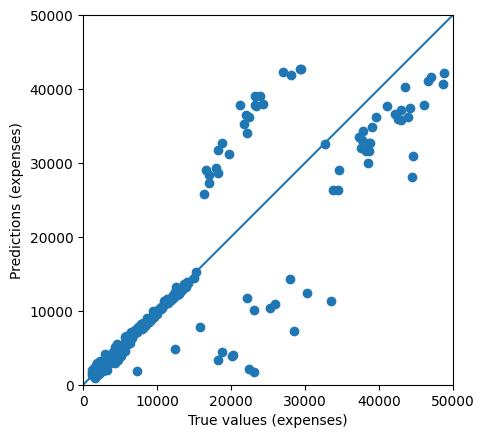

In [26]:
# ทดสอบโมเดลและประเมินผล
loss, mae = model.evaluate(test_dataset, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

# ตรวจสอบว่าผ่านเกณฑ์หรือไม่ (MAE ต้องน้อยกว่า 3500)
if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# พล็อตกราฟเปรียบเทียบค่าจริงกับค่าที่ทำนาย
test_predictions = model.predict(test_dataset).flatten()

# สร้างกราฟ scatter plot
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)  # เส้นทแยงมุม (perfect prediction line)